In [ ]:
import cv2
import numpy as np
import os
import glob

def combine_masks(healthy_dir, black_pod_rot_dir, pod_borer_dir, output_dir):
    """
    Combines individual class masks into multiclass masks
    0 = background, 1 = healthy, 2 = black_pod_rot, 3 = pod_borer
    """
    os.makedirs(output_dir, exist_ok=True)

    # Find all mask files (try multiple extensions)
    mask_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        mask_files.extend(glob.glob(os.path.join(healthy_dir, ext)))

    print(f"Found {len(mask_files)} mask files in {healthy_dir}")

    if len(mask_files) == 0:
        print(f"WARNING: No mask files found in {healthy_dir}")
        return

    for mask_path in mask_files:
        basename = os.path.basename(mask_path)

        # Read masks
        healthy = cv2.imread(os.path.join(healthy_dir, basename), cv2.IMREAD_GRAYSCALE)
        black_pod_rot = cv2.imread(os.path.join(black_pod_rot_dir, basename), cv2.IMREAD_GRAYSCALE)
        pod_borer = cv2.imread(os.path.join(pod_borer_dir, basename), cv2.IMREAD_GRAYSCALE)

        if healthy is None:
            print(f"Warning: Couldn't read healthy mask {basename}")
            continue

        # Create combined mask
        combined_mask = np.zeros_like(healthy, dtype=np.uint8)

        # Assign class labels
        if healthy is not None:
            combined_mask[healthy > 127] = 1  # healthy = 1
        if black_pod_rot is not None:
            combined_mask[black_pod_rot > 127] = 2  # black_pod_rot = 2
        if pod_borer is not None:
            combined_mask[pod_borer > 127] = 3  # pod_borer = 3

        # Save combined mask as PNG
        output_path = os.path.join(output_dir, os.path.splitext(basename)[0] + '.png')
        cv2.imwrite(output_path, combined_mask)

    print(f'Successfully created {len(mask_files)} combined masks in: {output_dir}')

# Create multiclass masks for TRAIN
combine_masks(
    healthy_dir='/content/drive/MyDrive/data/masks/train/healthy',
    black_pod_rot_dir='/content/drive/MyDrive/data/masks/train/black_pod_rot',
    pod_borer_dir='/content/drive/MyDrive/data/masks/train/pod_borer',
    output_dir='/content/drive/MyDrive/data/masks/train/Multiclass'
)

# Create multiclass masks for VAL
combine_masks(
    healthy_dir='/content/drive/MyDrive/data/masks/val/healthy',
    black_pod_rot_dir='/content/drive/MyDrive/data/masks/val/black_pod_rot',
    pod_borer_dir='/content/drive/MyDrive/data/masks/val/pod_borer',
    output_dir='/content/drive/MyDrive/data/masks/val/Multiclass'
)

Found 800 mask files in /content/drive/MyDrive/data/masks/train/healthy
Successfully created 800 combined masks in: /content/drive/MyDrive/data/masks/train/Multiclass
Found 200 mask files in /content/drive/MyDrive/data/masks/val/healthy
Successfully created 200 combined masks in: /content/drive/MyDrive/data/masks/val/Multiclass


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

# Parameters
IMG_SIZE = (128, 128)
NUM_CLASSES = 4  # background, healthy, black_pod_rot, pod_borer
BATCH_SIZE = 8
EPOCHS = 30

print(f"TensorFlow version: {tf.__version__}")
print(f"Image size: {IMG_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")

TensorFlow version: 2.19.0
Image size: (128, 128)
Number of classes: 4
Batch size: 8


In [ ]:
def show_files(image_dir, mask_dir, image_exts=('jpg', 'jpeg', 'png'), mask_exts=('png',)):
    """Display file counts and samples for debugging"""
    print(f"Image directory: {image_dir}")
    print(f"Mask directory: {mask_dir}")

    images = []
    for ext in image_exts:
        images += glob(os.path.join(image_dir, f'*.{ext}'))

    masks = []
    for ext in mask_exts:
        masks += glob(os.path.join(mask_dir, f'*.{ext}'))

    print(f"Image count: {len(images)}")
    print(f"Mask count: {len(masks)}")
    print(f"Sample images: {[os.path.basename(p) for p in images[:5]]}")
    print(f"Sample masks: {[os.path.basename(p) for p in masks[:5]]}")
    print("-" * 50)

    return images, masks

def get_matching_paths(image_dir, mask_dir, image_exts=('jpg', 'jpeg', 'png'), mask_exts=('png',)):
    """Get matching image-mask pairs"""
    images = []
    for ext in image_exts:
        images += glob(os.path.join(image_dir, f'*.{ext}'))

    masks = []
    for ext in mask_exts:
        masks += glob(os.path.join(mask_dir, f'*.{ext}'))

    # Create dictionaries for matching
    image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in images}
    mask_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in masks}

    # Find common keys
    common_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

    matched_images = [image_dict[k] for k in common_keys]
    matched_masks = [mask_dict[k] for k in common_keys]

    print(f"Matched {len(matched_images)} image-mask pairs")

    if len(common_keys) == 0:
        print("WARNING: No matching image/mask pairs found!")
        print("Sample image keys:", list(image_dict.keys())[:5])
        print("Sample mask keys:", list(mask_dict.keys())[:5])

    return matched_images, matched_masks

def process_data(image_path, mask_path):
    """Process image and mask for training"""
    # Load and process image
    image = tf.io.read_file(image_path)

    # Try to decode as JPEG first, then PNG
    try:
        image = tf.image.decode_jpeg(image, channels=3)
    except:
        image = tf.image.decode_png(image, channels=3)

    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    # Load and process mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.uint8)

    return image, mask

def load_dataset(image_dir, mask_dir, batch_size=8):
    """Load and prepare dataset"""
    image_paths, mask_paths = get_matching_paths(image_dir, mask_dir)

    if len(image_paths) == 0:
        print("ERROR: No matching image/mask pairs found!")
        return None

    # Create dataset
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    mask_ds = tf.data.Dataset.from_tensor_slices(mask_paths)

    dataset = tf.data.Dataset.zip((image_ds, mask_ds))
    dataset = dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Set data paths
train_img_dir = '/content/drive/MyDrive/data/images/train'
train_mask_dir = '/content/drive/MyDrive/data/masks/train/Multiclass'
val_img_dir = '/content/drive/MyDrive/data/images/val'
val_mask_dir = '/content/drive/MyDrive/data/masks/val/Multiclass'

# Check file counts
print("=== TRAINING DATA ===")
show_files(train_img_dir, train_mask_dir)

print("=== VALIDATION DATA ===")
show_files(val_img_dir, val_mask_dir)

# Load datasets
print("Loading datasets...")
train_dataset = load_dataset(train_img_dir, train_mask_dir, batch_size=BATCH_SIZE)
val_dataset = load_dataset(val_img_dir, val_mask_dir, batch_size=BATCH_SIZE)

if train_dataset is None or val_dataset is None:
    print("ERROR: Failed to load datasets. Please check your file paths and masks.")
else:
    print("✅ Datasets loaded successfully!")

=== TRAINING DATA ===
Image directory: /content/drive/MyDrive/data/images/train
Mask directory: /content/drive/MyDrive/data/masks/train/Multiclass
Image count: 2400
Mask count: 800
Sample images: ['image_322.jpg', 'image_322_jpg.rf.850d09e229fa3f0fbd28a0f1be467b94.jpg', 'image_322_jpg.rf.8e462b27e699d0b34cee92e3fa3be16e.jpg', 'image_323.jpg', 'image_323_jpg.rf.308dec59ce59a751f6046deea82e6a64.jpg']
Sample masks: ['image_10.png', 'image_100.png', 'image_1000.png', 'image_102.png', 'image_103.png']
--------------------------------------------------
=== VALIDATION DATA ===
Image directory: /content/drive/MyDrive/data/images/val
Mask directory: /content/drive/MyDrive/data/masks/val/Multiclass
Image count: 600
Mask count: 200
Sample images: ['image_1.jpg', 'image_1_jpg.rf.8c742fbdbebf910443ff0fe3c99199a8.jpg', 'image_10_jpg.rf.381652eafdc0de9d3fa4eab14c2c5566.jpg', 'image_1004_jpg.rf.df17039792beea7780a3391b0d9b51de.jpg', 'image_1008_jpg.rf.0e547e466d5a9fc2f28d6ce8e279c747.jpg']
Sample mask

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model

def build_unet(input_shape=(128, 128, 3), num_classes=4):
    """Build U-Net architecture for semantic segmentation"""
    inputs = Input(input_shape)

    # Encoder (Contracting Path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    d4 = Dropout(0.5)(c4)
    p4 = MaxPooling2D((2, 2))(d4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    d5 = Dropout(0.5)(c5)

    # Decoder (Expansive Path)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(d5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile model
print("Building U-Net model...")
model = build_unet(input_shape=(128, 128, 3), num_classes=NUM_CLASSES)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
model.summary()

Building U-Net model...
✅ Model compiled successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_9[0][0]  

 Total params: 31,031,940 (118.38 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if train_dataset is not None and val_dataset is not None:
    print("Starting training...")

    # Callbacks for better training
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            '/content/drive/MyDrive/models/best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Training completed!")

else:
    print("❌ Cannot train: Datasets not loaded properly")

Starting training...
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9480 - loss: 0.1730 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/models/best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1430s 14s/step - accuracy: 0.9484 - loss: 0.1717 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 1.0000 - loss: 0.0000e+00 
Epoch 2: val_accuracy did not improve from 1.00000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1416s 14s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 1.0000 - loss: 0.0000e+00 
Epoch 3: val_accuracy did not improve from 1.00000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1458s 14s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 

✅ Model saved successfully!


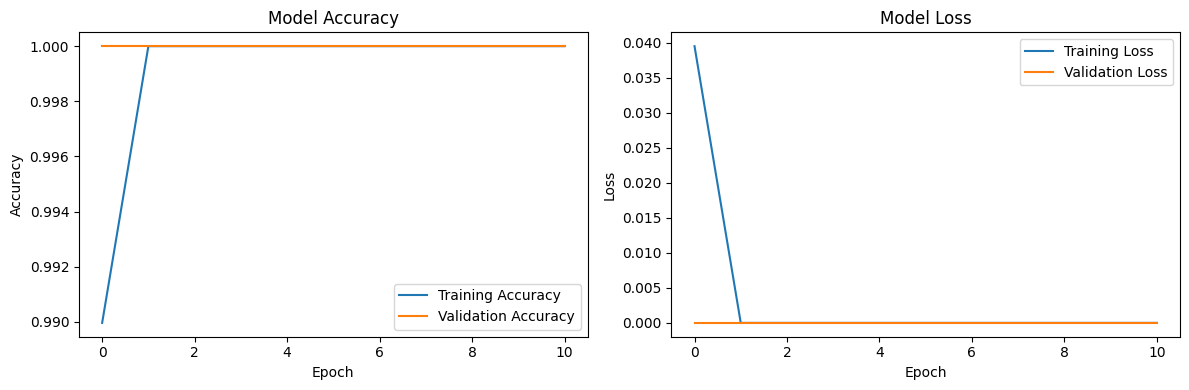

In [10]:
if 'history' in locals():
    # Create models directory
    os.makedirs('/content/drive/MyDrive/models', exist_ok=True)

    # Save final model
    model.save('/content/drive/MyDrive/models/cocoa_segmentation_final.keras')
    print("✅ Model saved successfully!")

    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("❌ No training history to save")

Model Predictions on Validation Data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


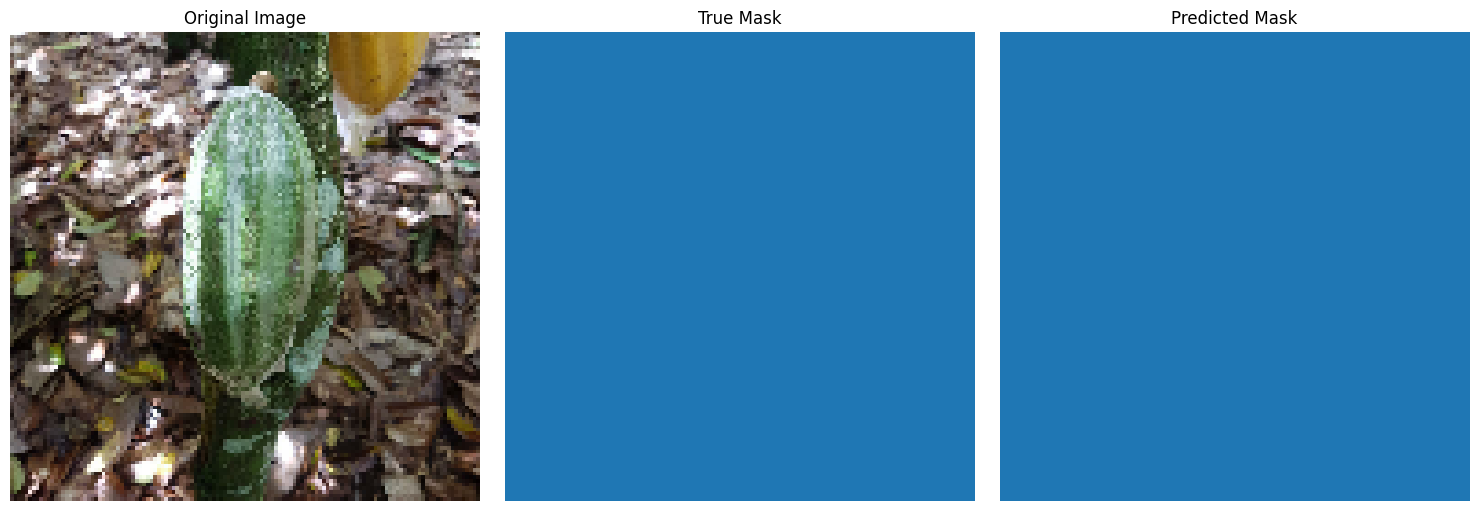

Sample 1:
  Background: True=16384, Predicted=16384
  Healthy: True=0, Predicted=0
  Black Pod Rot: True=0, Predicted=0
  Pod Borer: True=0, Predicted=0
----------------------------------------


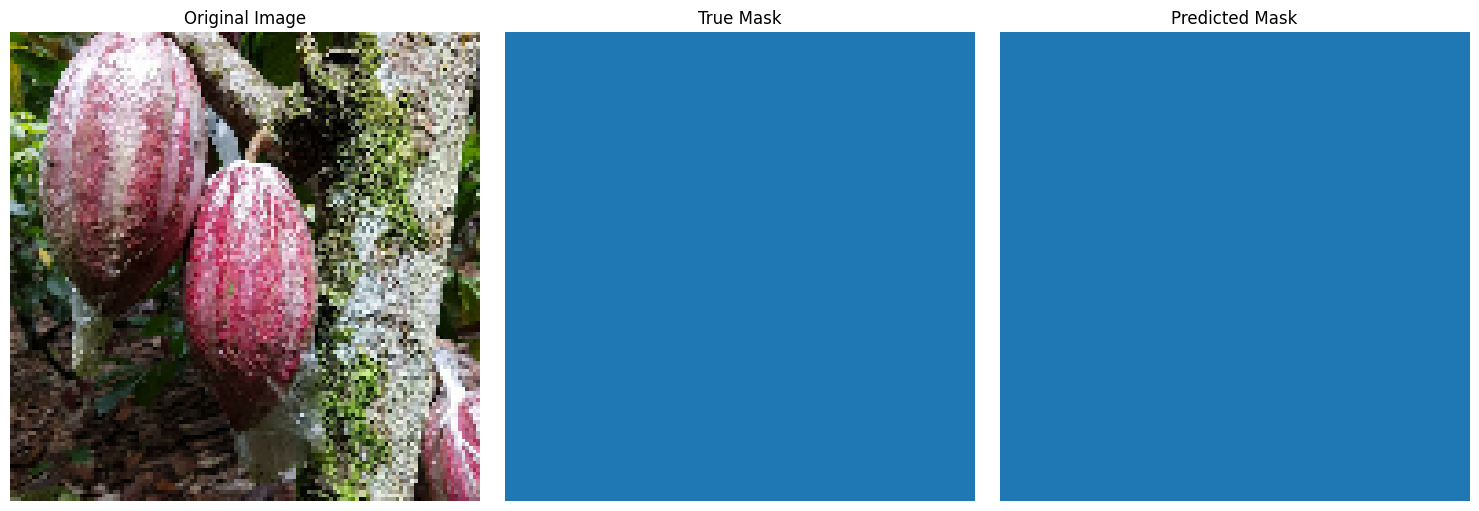

Sample 2:
  Background: True=16384, Predicted=16384
  Healthy: True=0, Predicted=0
  Black Pod Rot: True=0, Predicted=0
  Pod Borer: True=0, Predicted=0
----------------------------------------


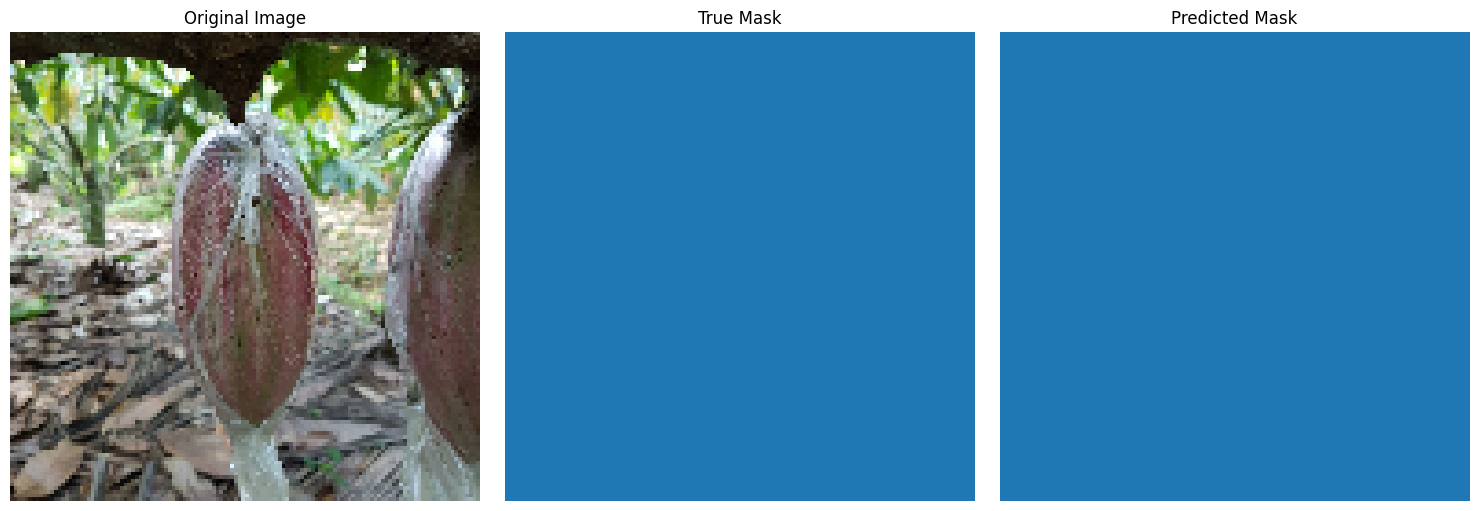

Sample 3:
  Background: True=16384, Predicted=16384
  Healthy: True=0, Predicted=0
  Black Pod Rot: True=0, Predicted=0
  Pod Borer: True=0, Predicted=0
----------------------------------------


In [11]:
def show_predictions(dataset, model, num_samples=3):
    """Display model predictions"""
    class_names = ['Background', 'Healthy', 'Black Pod Rot', 'Pod Borer']
    colors = ['black', 'green', 'red', 'blue']

    for images, masks in dataset.take(1):
        predictions = model.predict(images)
        predicted_masks = tf.argmax(predictions, axis=-1)

        for i in range(min(num_samples, len(images))):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Original image
            axes[0].imshow(images[i])
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            # True mask
            true_mask = masks[i].numpy().squeeze()
            axes[1].imshow(true_mask, cmap='tab10', vmin=0, vmax=3)
            axes[1].set_title('True Mask')
            axes[1].axis('off')

            # Predicted mask
            pred_mask = predicted_masks[i].numpy()
            axes[2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=3)
            axes[2].set_title('Predicted Mask')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            # Print class distribution
            print(f"Sample {i+1}:")
            for class_idx, class_name in enumerate(class_names):
                true_pixels = np.sum(true_mask == class_idx)
                pred_pixels = np.sum(pred_mask == class_idx)
                print(f"  {class_name}: True={true_pixels}, Predicted={pred_pixels}")
            print("-" * 40)

# Show predictions if model was trained
if 'history' in locals() and val_dataset is not None:
    print("Model Predictions on Validation Data:")
    show_predictions(val_dataset, model, num_samples=3)
else:
    print("❌ Cannot show predictions: Model not trained or validation data not available")

In [12]:
def predict_cocoa_disease(image_path, model_path='/content/drive/MyDrive/models/cocoa_segmentation_final.keras'):
    """
    Predict disease areas in a cocoa pod image
    """
    # Load model
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image.shape[:2]

    # Resize for model
    image_resized = cv2.resize(image, IMG_SIZE)
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)

    # Predict
    prediction = model.predict(image_batch)
    predicted_mask = tf.argmax(prediction, axis=-1)[0].numpy()

    # Resize back to original size
    predicted_mask_resized = cv2.resize(
        predicted_mask.astype(np.uint8),
        (original_shape[1], original_shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    # Calculate disease areas
    total_pixels = predicted_mask_resized.size
    healthy_pixels = np.sum(predicted_mask_resized == 1)
    black_pod_rot_pixels = np.sum(predicted_mask_resized == 2)
    pod_borer_pixels = np.sum(predicted_mask_resized == 3)

    results = {
        'healthy_percentage': (healthy_pixels / total_pixels) * 100,
        'black_pod_rot_percentage': (black_pod_rot_pixels / total_pixels) * 100,
        'pod_borer_percentage': (pod_borer_pixels / total_pixels) * 100,
        'predicted_mask': predicted_mask_resized,
        'original_image': image
    }

    return results

print("✅ Inference function ready!")
print("Use: results = predict_cocoa_disease('path/to/your/image.jpg')")

✅ Inference function ready!
Use: results = predict_cocoa_disease('path/to/your/image.jpg')


Test

In [13]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os
from PIL import Image

# Model parameters (same as training)
IMG_SIZE = (128, 128)
NUM_CLASSES = 4

# Class names and colors for visualization
CLASS_NAMES = ['Background', 'Healthy', 'Black Pod Rot', 'Pod Borer']
CLASS_COLORS = {
    0: [0, 0, 0],        # Background - Black
    1: [0, 255, 0],      # Healthy - Green
    2: [255, 0, 0],      # Black Pod Rot - Red
    3: [0, 0, 255]       # Pod Borer - Blue
}

# Load your trained model
MODEL_PATH = '/content/drive/MyDrive/models/cocoa_segmentation_final.keras'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Model loaded successfully!")
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure your model is trained and saved properly.")

✅ Model loaded successfully!
Model input shape: (None, 128, 128, 3)
Model output shape: (None, 128, 128, 4)


In [22]:
def upload_and_preprocess_image():
    """Upload and preprocess image for prediction"""
    print("Please upload a cocoa pod image for testing:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return None, None, None

    # Get the uploaded file
    filename = list(uploaded.keys())[0]

    # Read and preprocess the image
    image = cv2.imread(filename)
    if image is None:
        print("Error: Could not read the uploaded image!")
        return None, None, None

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image_rgb.shape[:2]

    # Resize for model input
    image_resized = cv2.resize(image_rgb, IMG_SIZE)
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)

    print(f"✅ Image loaded: {filename}")
    print(f"Original size: {original_shape}")
    print(f"Resized to: {IMG_SIZE}")

    return image_batch, image_rgb, original_shape

# Upload your test image
test_image_batch, original_image, original_shape = upload_and_preprocess_image()

Please upload a cocoa pod image for testing:


Saving 25100877527_1861118d5d_b.jpg to 25100877527_1861118d5d_b.jpg
✅ Image loaded: 25100877527_1861118d5d_b.jpg
Original size: (1024, 767)
Resized to: (128, 128)


In [23]:
def analyze_cocoa_pod(image_batch, original_image, original_shape, model):
    """
    Analyze cocoa pod image and return disease classification and segmentation
    """
    if image_batch is None:
        return None

    # Make prediction
    print("Making prediction...")
    prediction = model.predict(image_batch, verbose=0)
    predicted_mask = tf.argmax(prediction, axis=-1)[0].numpy()

    # Resize prediction back to original size
    predicted_mask_resized = cv2.resize(
        predicted_mask.astype(np.uint8),
        (original_shape[1], original_shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    # Calculate areas and percentages
    total_pixels = predicted_mask_resized.size
    background_pixels = np.sum(predicted_mask_resized == 0)
    healthy_pixels = np.sum(predicted_mask_resized == 1)
    black_pod_rot_pixels = np.sum(predicted_mask_resized == 2)
    pod_borer_pixels = np.sum(predicted_mask_resized == 3)

    # Calculate percentages (excluding background)
    pod_pixels = total_pixels - background_pixels

    if pod_pixels > 0:
        healthy_pct = (healthy_pixels / pod_pixels) * 100
        black_pod_rot_pct = (black_pod_rot_pixels / pod_pixels) * 100
        pod_borer_pct = (pod_borer_pixels / pod_pixels) * 100
    else:
        healthy_pct = black_pod_rot_pct = pod_borer_pct = 0

    # Determine overall pod health status
    disease_pixels = black_pod_rot_pixels + pod_borer_pixels
    disease_percentage = (disease_pixels / pod_pixels) * 100 if pod_pixels > 0 else 0

    if disease_percentage < 5:
        pod_status = "Healthy Pod"
        status_color = "green"
    elif disease_percentage < 25:
        pod_status = "Mild Disease"
        status_color = "orange"
    elif disease_percentage < 50:
        pod_status = "Moderate Disease"
        status_color = "orange"
    else:
        pod_status = "Severe Disease"
        status_color = "red"

    # Determine dominant disease type
    if black_pod_rot_pixels > pod_borer_pixels:
        dominant_disease = "Black Pod Rot"
    elif pod_borer_pixels > black_pod_rot_pixels:
        dominant_disease = "Pod Borer"
    else:
        dominant_disease = "Mixed Diseases" if disease_pixels > 0 else "No Disease"

    results = {
        'pod_status': pod_status,
        'status_color': status_color,
        'dominant_disease': dominant_disease,
        'disease_percentage': disease_percentage,
        'healthy_percentage': healthy_pct,
        'black_pod_rot_percentage': black_pod_rot_pct,
        'pod_borer_percentage': pod_borer_pct,
        'predicted_mask': predicted_mask_resized,
        'original_image': original_image,
        'total_pod_pixels': pod_pixels
    }

    return results

# Analyze the uploaded image
if test_image_batch is not None:
    results = analyze_cocoa_pod(test_image_batch, original_image, original_shape, model)
else:
    print("❌ No image to analyze. Please upload an image first.")

Making prediction...


/tmp/ipython-input-1194456383.py:71: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1194456383.py:71: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1194456383.py:71: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1194456383.py:71: UserWarning: Glyph 9899 (\N{MEDIUM BLACK CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


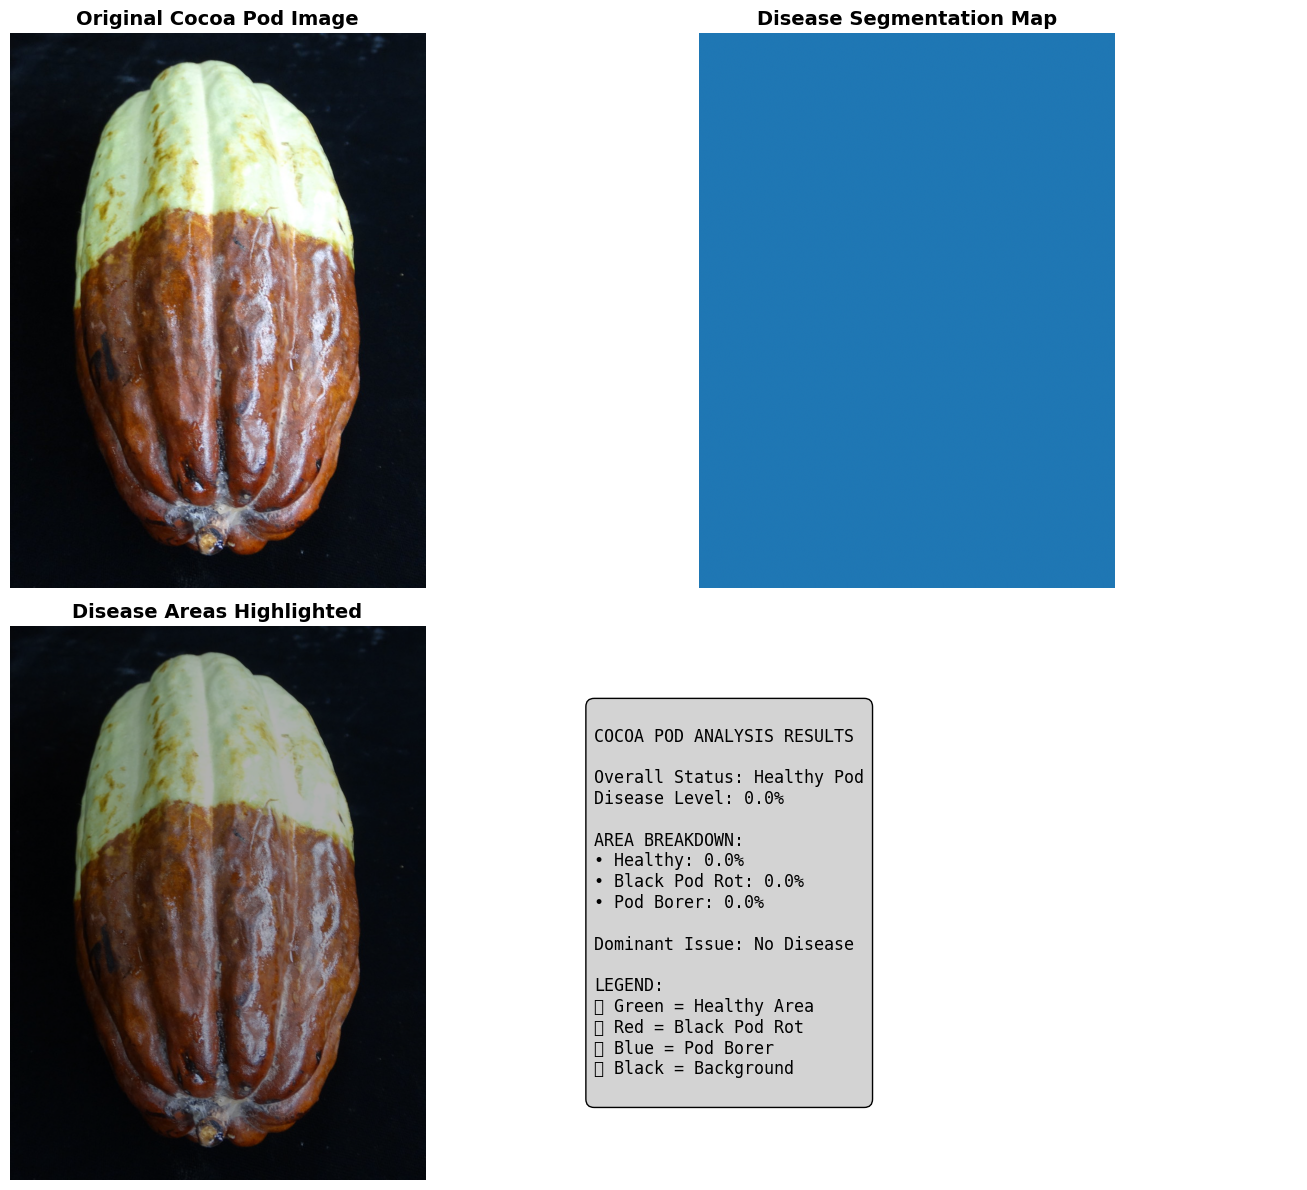

🔍 DETAILED ANALYSIS RESULTS
Pod Status: Healthy Pod
Overall Disease Level: 0.00%
Dominant Disease: No Disease

Area Distribution:
  • Healthy Areas: 0.00%
  • Black Pod Rot: 0.00%
  • Pod Borer: 0.00%

Total Pod Pixels Analyzed: 0

📋 RECOMMENDATION:
✅ Pod appears healthy. Continue regular monitoring.


In [24]:
def create_colored_mask(mask, alpha=0.6):
    """Create colored overlay mask for visualization"""
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    for class_id, color in CLASS_COLORS.items():
        colored_mask[mask == class_id] = color

    return colored_mask

def visualize_results(results):
    """Visualize prediction results"""
    if results is None:
        print("No results to visualize!")
        return

    original_image = results['original_image']
    predicted_mask = results['predicted_mask']

    # Create colored mask
    colored_mask = create_colored_mask(predicted_mask)

    # Create overlay
    overlay = cv2.addWeighted(original_image, 0.7, colored_mask, 0.3, 0)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Cocoa Pod Image', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    # Predicted mask
    axes[0, 1].imshow(predicted_mask, cmap='tab10', vmin=0, vmax=3)
    axes[0, 1].set_title('Disease Segmentation Map', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    # Overlay
    axes[1, 0].imshow(overlay)
    axes[1, 0].set_title('Disease Areas Highlighted', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    # Results summary
    axes[1, 1].axis('off')

    # Create text summary
    summary_text = f"""
COCOA POD ANALYSIS RESULTS

Overall Status: {results['pod_status']}
Disease Level: {results['disease_percentage']:.1f}%

AREA BREAKDOWN:
• Healthy: {results['healthy_percentage']:.1f}%
• Black Pod Rot: {results['black_pod_rot_percentage']:.1f}%
• Pod Borer: {results['pod_borer_percentage']:.1f}%

Dominant Issue: {results['dominant_disease']}

LEGEND:
🟢 Green = Healthy Area
🔴 Red = Black Pod Rot
🔵 Blue = Pod Borer
⚫ Black = Background
    """

    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12,
                    verticalalignment='center', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("=" * 60)
    print("🔍 DETAILED ANALYSIS RESULTS")
    print("=" * 60)
    print(f"Pod Status: {results['pod_status']}")
    print(f"Overall Disease Level: {results['disease_percentage']:.2f}%")
    print(f"Dominant Disease: {results['dominant_disease']}")
    print()
    print("Area Distribution:")
    print(f"  • Healthy Areas: {results['healthy_percentage']:.2f}%")
    print(f"  • Black Pod Rot: {results['black_pod_rot_percentage']:.2f}%")
    print(f"  • Pod Borer: {results['pod_borer_percentage']:.2f}%")
    print()
    print(f"Total Pod Pixels Analyzed: {results['total_pod_pixels']:,}")

    # Recommendation
    print()
    print("📋 RECOMMENDATION:")
    if results['disease_percentage'] < 5:
        print("✅ Pod appears healthy. Continue regular monitoring.")
    elif results['disease_percentage'] < 25:
        print("⚠️  Mild disease detected. Apply preventive treatment.")
    elif results['disease_percentage'] < 50:
        print("🔶 Moderate disease. Immediate treatment recommended.")
    else:
        print("🚨 Severe disease detected. Urgent intervention required!")

# Visualize results
if 'results' in locals() and results is not None:
    visualize_results(results)

In [17]:
def test_multiple_images():
    """Test multiple images at once"""
    print("Upload multiple images for batch testing:")
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded!")
        return

    all_results = []

    for filename in uploaded.keys():
        print(f"\n{'='*50}")
        print(f"Testing: {filename}")
        print('='*50)

        # Load and preprocess image
        image = cv2.imread(filename)
        if image is None:
            print(f"❌ Could not read {filename}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_shape = image_rgb.shape[:2]

        image_resized = cv2.resize(image_rgb, IMG_SIZE)
        image_normalized = image_resized.astype(np.float32) / 255.0
        image_batch = np.expand_dims(image_normalized, axis=0)

        # Analyze
        results = analyze_cocoa_pod(image_batch, image_rgb, original_shape, model)
        if results:
            results['filename'] = filename
            all_results.append(results)

            # Quick summary
            print(f"Status: {results['pod_status']}")
            print(f"Disease Level: {results['disease_percentage']:.1f}%")
            print(f"Dominant Issue: {results['dominant_disease']}")

    return all_results

# Uncomment to test multiple images
# batch_results = test_multiple_images()

In [18]:
def model_performance_summary():
    """Display model architecture and performance info"""
    print("🤖 MODEL INFORMATION")
    print("=" * 50)
    print(f"Model Type: U-Net for Semantic Segmentation")
    print(f"Input Size: {IMG_SIZE}")
    print(f"Number of Classes: {NUM_CLASSES}")
    print(f"Classes: {CLASS_NAMES}")
    print()

    print("🎯 MODEL CAPABILITIES")
    print("=" * 50)
    print("✅ Detects healthy cocoa pod areas")
    print("✅ Identifies Black Pod Rot disease")
    print("✅ Identifies Pod Borer disease")
    print("✅ Calculates disease percentages")
    print("✅ Provides treatment recommendations")
    print("✅ Creates visual disease maps")

    # Model summary
    print("\n📊 MODEL ARCHITECTURE")
    print("=" * 50)
    model.summary()

# Show model info
model_performance_summary()

🤖 MODEL INFORMATION
Model Type: U-Net for Semantic Segmentation
Input Size: (128, 128)
Number of Classes: 4
Classes: ['Background', 'Healthy', 'Black Pod Rot', 'Pod Borer']

🎯 MODEL CAPABILITIES
✅ Detects healthy cocoa pod areas
✅ Identifies Black Pod Rot disease
✅ Identifies Pod Borer disease
✅ Calculates disease percentages
✅ Provides treatment recommendations
✅ Creates visual disease maps

📊 MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_9[0][0]  

 Total params: 93,095,822 (355.13 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,063,882 (236.75 MB)